## Installs

In [1]:
!pip install interpret

# Imports

In [2]:
from google.colab import drive
import os
%load_ext autoreload
%autoreload 2

drive.mount('/content/gdrive', force_remount=True)
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from pycaret.classification import *
from sklearn.metrics import fbeta_score,make_scorer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.linear_model import LogisticRegression
from interpret import show

# from joblib import dump, load
# from collections import namedtuple

%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_rows', 100)

In [4]:
# from pycaret.utils import enable_colab
# # from pycaret.classification import *
# enable_colab()

# Experiment

In [5]:
def compute_metrics_binary(y_true, y_pred_proba = None,threshold = 0.5,verbose=0):
    
    y_pred_label = y_pred_proba
    y_pred_label[y_pred_proba >= threshold] = 1
    y_pred_label[y_pred_proba < threshold] = 0
    
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_label)
    f1score = f1_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    conf_mat = confusion_matrix(y_true, y_pred_label)

    if verbose > 0:
        print('----------------')
        print("Total samples in batch:",y_true.shape)
        print("AUC:       %1.3f" % auc)
        print("Accuracy:  %1.3f" % accuracy)
        print("F1:        %1.3f" % f1score)
        print("Precision: %1.3f" % precision)
        print("Recall:    %1.3f" % recall)
        print("Confusion Matrix: \n", conf_mat)
        print('----------------')
    metrics = {
        'auc':auc,
        'accuracy':accuracy,
        'f1score':f1score,
        'precision':precision,
        'recall':recall,
        'conf_mat':conf_mat
    }
    return metrics


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def show_feature_weights(features, coefficients,model_title, color = None, absolute_values = False, normalized = False,figsize=(8,8),top=None):

    '''
      Show a feature importance bar plot by feature weights.
      
      Parameters:
      features: vector with the feature names
      coefficients: 1-D array values of weights given to features.
      model_title: Name of the model
      color: Tuple to give different colors to positive and negative weights. Example: color = ('red','green')
      absolute_values: Flag to analyse just absolute values of weights
      normalized: Flag to normalize the feature weights 
      top: show only top most important features.
    '''
    
    df_weights = create_normalized_by_feature_weight(features,coefficients);
    column = 'Weights'
    if absolute_values:
        column = 'abs_Weights'
    if normalized:
        column = column.replace('Weights','normalized')

    df_weights = df_weights.sort_values(by=[column],ascending = True,inplace = False)
    fig,ax = plt.subplots(1,figsize=figsize)
    colors = (0.2,0.4,0.8)
    if color is not None:
        color_mask = df_weights['normalized'] > 0
        colors = [color[0] if c else color[1] for c in color_mask]
        legend_elements = [
            Patch(facecolor = color[1], edgecolor='k', label='Negative Contribution'),
            Patch(facecolor = color[0], edgecolor='k', label='Positive Contribution')]
    
    ax.tick_params(axis = 'both',labelsize = 'large')
    df_weights[column].plot(kind = 'barh', grid = True, color = colors,edgecolor='k', alpha = 0.6,ax = ax)
    fig.suptitle(f'Feature Weights - {model_title}',x = 0.3,fontsize = 20)

    if color:
        ax.legend(handles=legend_elements, bbox_to_anchor=(1, -0.05), borderaxespad=0.,fancybox=True, shadow=True,ncol = 2)

    if normalized:
        plt.figtext(0.91, 0.03, '*All values add up to one', horizontalalignment='right')
    if absolute_values:
        plt.figtext(0.91, 0.01, '*All values are absolute', horizontalalignment='right')

    plt.subplots_adjust(top=0.93, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)
    plt.show()


def create_normalized_by_feature_weight(features,coefficients):
    
    '''
        Create a Dataframe based on the Weights given to each feature by linear models, with the following columns:
          Weights: Weights of each feature
          abs_Weights: Absolute value of the weights
          normalized: Normalized weights (all values of this column add up to one)
          abs_normalized: Absolute value of the feature importance
      
        Parameters:
          features: 1-D array with the feature names
          coefficients: 1-D array values of weights given to features.
    '''

    df_weights = pd.DataFrame(index = features,columns = ['Weights'])
    df_weights['Weights'] = coefficients
    df_weights['abs_Weights'] = np.abs(df_weights['Weights'])
    total_weights = df_weights['abs_Weights'].values.ravel().sum()
    df_weights['normalized'] = df_weights['Weights'].values / total_weights
    df_weights['abs_normalized'] = df_weights['abs_Weights'].values / total_weights
    df_weights.sort_values(by=['abs_normalized'],ascending = False,inplace = True)
    return df_weights

In [7]:
import math
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.special import erfcinv
from statsmodels.stats import proportion

def calculate_sensibility_at_level(tpr, fpr, level):
    level_fpr = 1 - level  # fpr is (1-specificity)
    f_sens = interp1d(fpr, tpr)  # interpolate sensibility (tpr = sensibility)
    return (f_sens(level_fpr))


def find_optimal_cutoff(fpr, tpr, thresholds):
    """ Find the optimal probability cutoff point for a classification model related to event rate
        Parameters
        ----------
        fpr: False positive rate

        tpr : True positive rate

        Returns
        -------
        cutoff value

        """
    #optimal_idx = np.argmax(tpr - fpr)
    optimal_idx = np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))  # Minimum distance to the upper left corner (By Pathagoras' theorem)
    optimal_threshold = thresholds[optimal_idx]
    optimal_sensitivity = tpr[optimal_idx]
    optimal_specificity = 1 - fpr[optimal_idx]
    return optimal_sensitivity, optimal_specificity, optimal_threshold


def se_auc(auc, cls):
    """
    Standard error of area
    :param auc: area under the curve
    :param cls: the column of the tag: unhealthy (1) and healthy (0)
    :return: standard error
    """
    auc2 = auc ** 2
    q1 = auc / (2 - auc)
    q2 = 2 * auc2 / (1 + auc)
    lu = sum(cls == 1)  # Number of unhealthy subjects (class == 1)
    lh = sum(cls == 0)  # Number of healthy subjects (class == 0)
    V = (auc * (1 - auc) + (lu - 1) * (q1 - auc2) + (lh - 1) * (q2 - auc2)) / (lu * lh)
    se = math.sqrt(V)
    return se


def ci_auc(auc, se, alpha=0.05):
    """
    Confidence interval of AUC
    :param auc: area under the curve
    :param se: standard error
    :param alpha: significance level (default = 0.05)
    :return: confidence interval
    """
    ci_lo = auc + (-1 * math.sqrt(2) * erfcinv(alpha) * se)
    ci_up = auc + (math.sqrt(2) * erfcinv(alpha) * se)
    return ci_lo, ci_up


def ci_sen(optimal_sensitivity, cls):
    """
    Confidence interval of Sensitivity using Simple Asymptotic
    :param optimal_sensitivity: optimal cutoff point
    :param cls: the column of the tag: unhealthy (1) and healthy (0)
    :return: confidence interval - array[(low, high)]
    """
    num_u = sum(cls == 1)  # Number of unhealthy subjects (class == 1)
    sa = 1.96 * math.sqrt(optimal_sensitivity * (1 - optimal_sensitivity) / num_u)
    ci_sen = np.zeros(2)
    ci_sen = [optimal_sensitivity - sa, optimal_sensitivity + sa]
    return ci_sen


def ci_spe(optimal_specificity, cls):
    """
        Confidence interval of Specificity using Simple Asymptotic
        :param optimal_specificity: optimal cutoff point
        :param cls: the column of the tag: unhealthy (1) and healthy (0)
        :return: confidence interval - array[(low, high)]
    """
    num_h = sum(cls == 0)  # Number of healthy subjects (class == 0)
    sa = 1.96 * math.sqrt(optimal_specificity * (1 - optimal_specificity) / num_h)
    ci_spe = np.zeros(2)
    ci_spe = [optimal_specificity - sa, optimal_specificity + sa]
    return ci_spe


def plotroc(df, models, levels=[0.75,0.9],label='DIAGNOSIS'):

    roc_df = pd.DataFrame(columns=['SensLevel0', 'SensLevel1',
                                   'AUC', 'AucCI_lo', 'AucCI_hi',
                                   'SE',
                                   'OpSen', 'SenCI_lo', 'SenCI_hi',
                                   'OpSpe', 'SpeCI_lo', 'SpeCI_hi'])
    classes = df[label]

    fig =plt.figure(figsize=(8,8))

    for model in models:

        sens = [math.nan, math.nan]  # create a list to hold the sensibility
        # model = m['model']  # select the model
        y_proba = model.predict(df.drop(label,axis=1))

        # Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(classes, y_proba, drop_intermediate=False)
        # Calculate Area under the curve to display on the plot
        # auc = metrics.roc_auc_score(y_test, model.predict(x_test))
        roc_df.loc[model, 'AUC'] = metrics.auc(fpr, tpr)

        # calculate the sensitivity at levels
        roc_df.loc[model, 'SensLevel0'] = calculate_sensibility_at_level(tpr, fpr, levels[0])
        roc_df.loc[model, 'SensLevel1'] = calculate_sensibility_at_level(tpr, fpr, levels[1])

        # Calculate the standard error of AUC
        roc_df.loc[model, 'SE'] = se_auc(roc_df.loc[model, 'AUC'], classes)

        # Calculate the confidence interval of AUC
        roc_df.loc[model, ['AucCI_lo', 'AucCI_hi']] = ci_auc(roc_df.loc[model, 'AUC'], roc_df.loc[model, 'SE'])

        # Calculate the optimal cutoff point, Sensitivity and specificity
        roc_df.loc[model, 'OpSen'], roc_df.loc[model, 'OpSpe'], optimal_threshold = find_optimal_cutoff(fpr, tpr, thresholds)

        # Calculate the confidence interval of Sensitivity
        roc_df.loc[model, ['SenCI_lo', 'SenCI_hi']] = ci_sen(roc_df.loc[model, 'OpSen'], classes)

        # Calculate the confidence interval of Specificity
        roc_df.loc[model, ['SpeCI_lo', 'SpeCI_hi']] = ci_spe(roc_df.loc[model, 'OpSpe'], classes)

        # fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        # roc_auc = metrics.auc(fpr, tpr)
        # Now, plot the computed values
        model_name = type(model).__name__
        plt.plot(fpr, tpr, label=model_name)
    # Custom settings for the plot
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()  # Display
    #plt.savefig(filename, format='png', dpi=300)
    return roc_df, fig


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Experiment1 using Features Coronal43, Axial23, Sagittal23, CognitiveTestScore

In [8]:
mri_data_path = './data/PREDICTIONS_VGG19_BN_DATA_AUG_LR_0001.csv'
cognitive_tests_data_path = './data/PREDICTIONS_COGNITIVE_TESTS.csv'
labels=[0,1]
model_path = ''
experiment_name = 'ADNI_CN_AD'
label_column = 'DIAGNOSIS'
n_splits = 5
selected_models = ['lightgbm','lr',ExplainableBoostingClassifier()] 

# Merging predictions
df_mri = pd.read_csv(mri_data_path)
df_mri['CNN_LABEL'].replace({False:0,True:1},inplace=True)
df_mri = df_mri.query("ROTATION_ANGLE == 0 and DATASET in ('train','test','validation')")[['SUBJECT','IMAGE_DATA_ID','ORIENTATION','SLICE','RUN_ID','CNN_LABEL','CNN_SCORE','MACRO_GROUP','DATASET']]
df_mri = df_mri.pivot_table(index=['SUBJECT','IMAGE_DATA_ID','DATASET','MACRO_GROUP'],values=['CNN_LABEL','CNN_SCORE'],columns=['RUN_ID'])
df_mri.columns = [x[0]+'_'+x[1].upper() for x in df_mri.columns]
df_mri.reset_index(inplace=True)
df_mri.drop(["CNN_LABEL_AXIAL23",'CNN_LABEL_CORONAL43','CNN_LABEL_SAGITTAL26','MACRO_GROUP'],axis=1,inplace=True)

df_cog = pd.read_csv(cognitive_tests_data_path)
df_cog.rename(columns={"IMAGEUID":"IMAGE_DATA_ID"},inplace=True)
df_cog = df_cog.query("DATASET in  ('train','test','validation')")[['SUBJECT','IMAGE_DATA_ID','DATASET','Score_1','DIAGNOSIS']].reset_index(drop=True)
df_cog['IMAGE_DATA_ID'] = 'I' + df_cog['IMAGE_DATA_ID'].astype(str)
df_ensemble = df_mri.merge(df_cog,on=['SUBJECT','IMAGE_DATA_ID','DATASET'])

df_train = df_ensemble.query("DATASET in ('train') and DIAGNOSIS in @labels").drop(['SUBJECT','IMAGE_DATA_ID','DATASET'],axis=1)
df_validation = df_ensemble.query("DATASET == 'validation' and DIAGNOSIS in @labels").drop(['SUBJECT','IMAGE_DATA_ID','DATASET'],axis=1)
df_test = df_ensemble.query("DATASET == 'test' and DIAGNOSIS in @labels").drop(['SUBJECT','IMAGE_DATA_ID','DATASET'],axis=1)

In [9]:
ebm = ExplainableBoostingClassifier()
ebm.fit(df_train.drop('DIAGNOSIS',axis=1),df_train['DIAGNOSIS'])

lr = LogisticRegression()
lr.fit(df_train.drop('DIAGNOSIS',axis=1),df_train['DIAGNOSIS'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
df = df_test
y_pred_proba = ebm.predict_proba(df.drop('DIAGNOSIS',axis=1))[:,-1]
y_true = df['DIAGNOSIS']
print("EBM Results for Test:")
ebm_result_metrics = compute_metrics_binary(y_true, y_pred_proba = y_pred_proba,threshold = 0.5,verbose=1)

print("\n Logistic Regression Results for Test:")
y_pred_proba = lr.predict_proba(df.drop('DIAGNOSIS',axis=1))[:,-1]
lr_result_metrics = compute_metrics_binary(y_true, y_pred_proba = y_pred_proba,threshold = 0.5,verbose=1)

EBM Results for Test:
----------------
Total samples in batch: (349,)
AUC:       0.991
Accuracy:  0.994
F1:        0.985
Precision: 0.985
Recall:    0.985
Confusion Matrix: 
 [[282   1]
 [  1  65]]
----------------

 Logistic Regression Results for Test:
----------------
Total samples in batch: (349,)
AUC:       0.968
Accuracy:  0.986
F1:        0.961
Precision: 0.984
Recall:    0.939
Confusion Matrix: 
 [[282   1]
 [  4  62]]
----------------


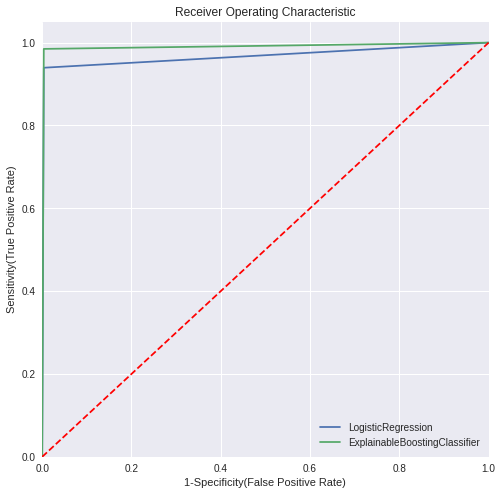

,SensLevel0,SensLevel1,AUC,AucCI_lo,AucCI_hi,SE,OpSen,SenCI_lo,SenCI_hi,OpSpe,SpeCI_lo,SpeCI_hi
"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n warm_start=False)",0.9543842682140555,0.9452611218568666,0.96793,0.937851,0.99801,0.015347,0.939394,0.881828,0.99696,0.996466,0.989553,1.00338
"ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,\n early_stopping_tolerance=0.0001,\n feature_names=['CNN_SCORE_AXIAL23',\n 'CNN_SCORE_CORONAL43',\n 'CNN_SCORE_SAGITTAL26', 'Score_1',\n 'CNN_SCORE_AXIAL23 x Score_1',\n 'CNN_SCORE_CORONAL43 x Score_1',\n 'CNN_SCORE_SAGITTAL26 x Score_1',\n 'CNN_SCORE_AXIAL23 x '\n 'CNN_SCORE_CORONAL43',\n 'CNN_SCORE_CORONAL43 x '\n '...\n feature_types=['continuous', 'continuous',\n 'continuous', 'continuous',\n 'interaction', 'interaction',\n 'interaction', 'interaction',\n 'interaction', 'interaction'],\n inner_bags=0, interactions=10, learning_rate=0.01,\n mains='all', max_bins=256,\n max_interaction_bins=32, max_leaves=3,\n max_rounds=5000, min_samples_leaf=2, n_jobs=-2,\n outer_bags=8, random_state=42,\n validation_size=0.15)",0.9885960670535139,0.9863152804642167,0.990657,0.97422,1.00709,0.00838651,0.984848,0.955377,1.01432,0.996466,0.989553,1.00338


In [11]:
df_roc,_ = plotroc(df, models=[lr,ebm])
df_roc

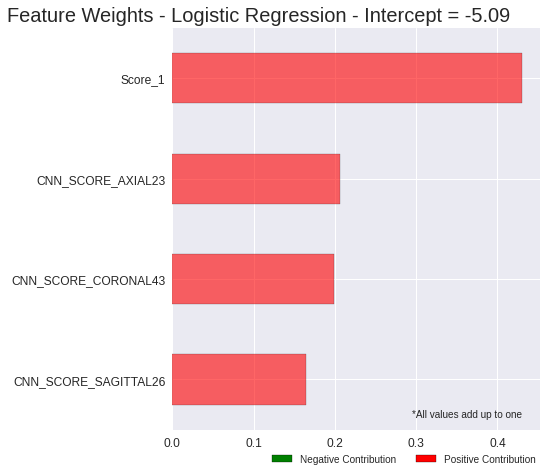

In [12]:
features = df_test.columns[:-1]
show_feature_weights(features,lr.coef_.ravel(),'Logistic Regression - Intercept = %3.2f' % lr.intercept_[0], color = ('r','g'),figsize=(6,6), absolute_values = False,normalized=True)

In [13]:
show(ebm.explain_global())

/usr/local/lib/python3.7/dist-packages/interpret/provider/visualize.py:44: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  detected_envs


In [14]:
ebm_local = ebm.explain_local(df_test.drop('DIAGNOSIS',axis=1),df_test['DIAGNOSIS'])
show(ebm_local)

Output hidden; open in https://colab.research.google.com to view.

## Experiment 2 using Features Coronal43, Axial23, Sagittal23

In [15]:
mri_data_path = './data/PREDICTIONS_VGG19_BN_DATA_AUG_LR_0001.csv'
cognitive_tests_data_path = './data/PREDICTIONS_COGNITIVE_TESTS.csv'
labels=[0,1]
model_path = ''
experiment_name = 'ADNI_CN_AD'
label_column = 'DIAGNOSIS'
n_splits = 5
selected_models = ['lightgbm','lr',ExplainableBoostingClassifier()] 

# Merging predictions
df_mri = pd.read_csv(mri_data_path)
df_mri['CNN_LABEL'].replace({False:0,True:1},inplace=True)
df_mri = df_mri.query("ROTATION_ANGLE == 0 and DATASET in ('train','test','validation')")[['SUBJECT','IMAGE_DATA_ID','ORIENTATION','SLICE','RUN_ID','CNN_LABEL','CNN_SCORE','MACRO_GROUP','DATASET']]
df_mri = df_mri.pivot_table(index=['SUBJECT','IMAGE_DATA_ID','DATASET','MACRO_GROUP'],values=['CNN_LABEL','CNN_SCORE'],columns=['RUN_ID'])
df_mri.columns = [x[0]+'_'+x[1].upper() for x in df_mri.columns]
df_mri.reset_index(inplace=True)
df_mri.drop(["CNN_LABEL_AXIAL23",'CNN_LABEL_CORONAL43','CNN_LABEL_SAGITTAL26','MACRO_GROUP'],axis=1,inplace=True)

df_cog = pd.read_csv(cognitive_tests_data_path)
df_cog.rename(columns={"IMAGEUID":"IMAGE_DATA_ID"},inplace=True)
df_cog = df_cog.query("DATASET in  ('train','test','validation')")[['SUBJECT','IMAGE_DATA_ID','DATASET','Score_1','DIAGNOSIS']].reset_index(drop=True)
df_cog['IMAGE_DATA_ID'] = 'I' + df_cog['IMAGE_DATA_ID'].astype(str)
df_ensemble = df_mri.merge(df_cog,on=['SUBJECT','IMAGE_DATA_ID','DATASET']).drop('Score_1',axis=1)

df_train = df_ensemble.query("DATASET in ('train') and DIAGNOSIS in @labels").drop(['SUBJECT','IMAGE_DATA_ID','DATASET'],axis=1)
df_validation = df_ensemble.query("DATASET == 'validation' and DIAGNOSIS in @labels").drop(['SUBJECT','IMAGE_DATA_ID','DATASET'],axis=1)
df_test = df_ensemble.query("DATASET == 'test' and DIAGNOSIS in @labels").drop(['SUBJECT','IMAGE_DATA_ID','DATASET'],axis=1)

In [16]:
ebm = ExplainableBoostingClassifier()
ebm.fit(df_train.drop('DIAGNOSIS',axis=1),df_train['DIAGNOSIS'])

lr = LogisticRegression()
lr.fit(df_train.drop('DIAGNOSIS',axis=1),df_train['DIAGNOSIS'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
df = df_test
y_pred_proba = ebm.predict_proba(df.drop('DIAGNOSIS',axis=1))[:,-1]
y_true = df['DIAGNOSIS']
print("EBM Results for Test:")
ebm_result_metrics = compute_metrics_binary(y_true, y_pred_proba = y_pred_proba,threshold = 0.5,verbose=1)

print("\n Logistic Regression Results for Test:")
y_pred_proba = lr.predict_proba(df.drop('DIAGNOSIS',axis=1))[:,-1]
lr_result_metrics = compute_metrics_binary(y_true, y_pred_proba = y_pred_proba,threshold = 0.5,verbose=1)

EBM Results for Test:
----------------
Total samples in batch: (349,)
AUC:       0.826
Accuracy:  0.905
F1:        0.736
Precision: 0.780
Recall:    0.697
Confusion Matrix: 
 [[270  13]
 [ 20  46]]
----------------

 Logistic Regression Results for Test:
----------------
Total samples in batch: (349,)
AUC:       0.857
Accuracy:  0.928
F1:        0.797
Precision: 0.860
Recall:    0.742
Confusion Matrix: 
 [[275   8]
 [ 17  49]]
----------------


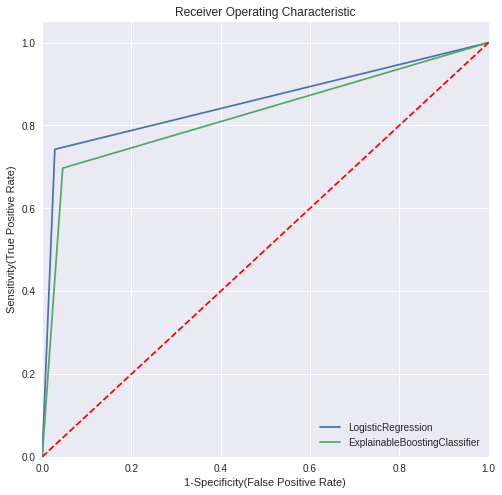

,SensLevel0,SensLevel1,AUC,AucCI_lo,AucCI_hi,SE,OpSen,SenCI_lo,SenCI_hi,OpSpe,SpeCI_lo,SpeCI_hi
"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n warm_start=False)",0.801198347107438,0.7614380165289256,0.857078,0.797842,0.916313,0.0302228,0.742424,0.636922,0.847927,0.971731,0.952421,0.991042
"ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,\n early_stopping_tolerance=0.0001,\n feature_names=['CNN_SCORE_AXIAL23',\n 'CNN_SCORE_CORONAL43',\n 'CNN_SCORE_SAGITTAL26',\n 'CNN_SCORE_AXIAL23 x '\n 'CNN_SCORE_CORONAL43',\n 'CNN_SCORE_AXIAL23 x '\n 'CNN_SCORE_SAGITTAL26',\n 'CNN_SCORE_CORONAL43 x '\n 'CNN_SCORE_SAGITTAL26'],\n feature_types=['continuous', 'continuous',\n 'continuous', 'interaction',\n 'interaction', 'interaction'],\n inner_bags=0, interactions=10, learning_rate=0.01,\n mains='all', max_bins=256,\n max_interaction_bins=32, max_leaves=3,\n max_rounds=5000, min_samples_leaf=2, n_jobs=-2,\n outer_bags=8, random_state=42,\n validation_size=0.15)",0.7617845117845118,0.7141414141414142,0.825517,0.761537,0.889497,0.0326435,0.69697,0.586095,0.807845,0.954064,0.929673,0.978455


In [18]:
df_roc,_ = plotroc(df, models=[lr,ebm])
df_roc

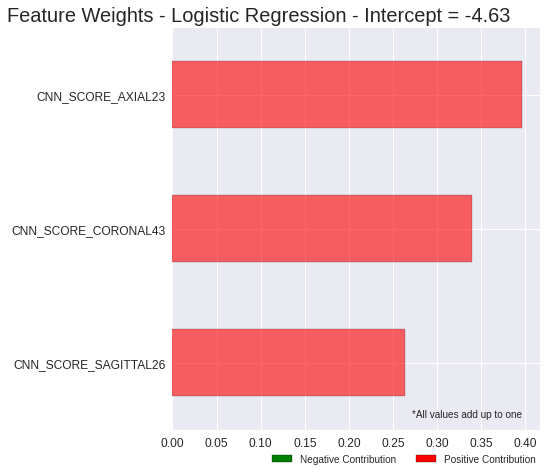

In [19]:
features = df_test.columns[:-1]
show_feature_weights(features,lr.coef_.ravel(),'Logistic Regression - Intercept = %3.2f' % lr.intercept_[0], color = ('r','g'),figsize=(6,6), absolute_values = False,normalized=True)

In [20]:
show(ebm.explain_global())

In [21]:
ebm_local = ebm.explain_local(df_test.drop('DIAGNOSIS',axis=1),df_test['DIAGNOSIS'])
show(ebm_local)

Output hidden; open in https://colab.research.google.com to view.

## Experiment 3 using Features Coronal43, Axial23, Sagittal23 + Demographics

In [22]:
mri_data_path = './data/PREDICTIONS_VGG19_BN_DATA_AUG_LR_0001.csv'
cognitive_tests_data_path = './data/PREDICTIONS_COGNITIVE_TESTS.csv'
demographics_data_path = './data/tabular/COGNITIVE_DATA_PREPROCESSED.csv'
labels=[0,1]
model_path = ''
experiment_name = 'ADNI_CN_AD'
label_column = 'DIAGNOSIS'
n_splits = 5
selected_models = ['lightgbm','lr',ExplainableBoostingClassifier()] 

# Preparing MRI predictions
df_mri = pd.read_csv(mri_data_path)
df_mri['CNN_LABEL'].replace({False:0,True:1},inplace=True)
df_mri = df_mri.query("ROTATION_ANGLE == 0 and DATASET in ('train','test','validation')")[['SUBJECT','IMAGE_DATA_ID','ORIENTATION','SLICE','RUN_ID','CNN_LABEL','CNN_SCORE','MACRO_GROUP','DATASET']]
df_mri = df_mri.pivot_table(index=['SUBJECT','IMAGE_DATA_ID','DATASET','MACRO_GROUP'],values=['CNN_LABEL','CNN_SCORE'],columns=['RUN_ID'])
df_mri.columns = [x[0]+'_'+x[1].upper() for x in df_mri.columns]
df_mri.reset_index(inplace=True)
df_mri.drop(["CNN_LABEL_AXIAL23",'CNN_LABEL_CORONAL43','CNN_LABEL_SAGITTAL26','MACRO_GROUP'],axis=1,inplace=True)

# Preparing Cognitive Tests Data (won't be used, just for filtering)
df_cog = pd.read_csv(cognitive_tests_data_path)
df_cog.rename(columns={"IMAGEUID":"IMAGE_DATA_ID"},inplace=True)
df_cog = df_cog.query("DATASET in  ('train','test','validation')")[['SUBJECT','IMAGE_DATA_ID','DATASET','Score_1','DIAGNOSIS']].reset_index(drop=True)
df_cog['IMAGE_DATA_ID'] = 'I' + df_cog['IMAGE_DATA_ID'].astype(str)

# Preparing Demographics
demographics_data_path = './data/tabular/COGNITIVE_DATA_PREPROCESSED.csv'
df_demographics = pd.read_csv(demographics_data_path)[['SUBJECT','IMAGEUID','AGE','MALE','YEARS_EDUCATION','HISPANIC','RACE_WHITE','RACE_BLACK','RACE_ASIAN','MARRIED','WIDOWED','DIVORCED','NEVER_MARRIED',]]
df_demographics.rename(columns={"IMAGEUID":"IMAGE_DATA_ID"},inplace=True)
df_demographics['IMAGE_DATA_ID'] = 'I' + df_demographics['IMAGE_DATA_ID'].astype(str)

# Merging predictions
df_ensemble = df_mri.merge(df_cog,on=['SUBJECT','IMAGE_DATA_ID','DATASET']).drop('Score_1',axis=1)
df_ensemble = df_ensemble.merge(df_demographics,on=['SUBJECT','IMAGE_DATA_ID'])[['SUBJECT','IMAGE_DATA_ID','DATASET',
                                                  'CNN_SCORE_AXIAL23', 'CNN_SCORE_CORONAL43', 'CNN_SCORE_SAGITTAL26',
                                                  'AGE', 'MALE', 'YEARS_EDUCATION', 'HISPANIC', 'RACE_WHITE',
                                                  'RACE_BLACK', 'RACE_ASIAN', 'MARRIED','DIAGNOSIS']]

df_train = df_ensemble.query("DATASET in ('train') and DIAGNOSIS in @labels").drop(['SUBJECT','IMAGE_DATA_ID','DATASET'],axis=1)
df_validation = df_ensemble.query("DATASET == 'validation' and DIAGNOSIS in @labels").drop(['SUBJECT','IMAGE_DATA_ID','DATASET'],axis=1)
df_test = df_ensemble.query("DATASET == 'test' and DIAGNOSIS in @labels").drop(['SUBJECT','IMAGE_DATA_ID','DATASET'],axis=1)

In [23]:
ebm = ExplainableBoostingClassifier()
ebm.fit(df_train.drop('DIAGNOSIS',axis=1),df_train['DIAGNOSIS']);

lr = LogisticRegression(max_iter=500)
lr.fit(df_train.drop('DIAGNOSIS',axis=1),df_train['DIAGNOSIS']);

In [24]:
df = df_test
y_pred_proba = ebm.predict_proba(df.drop('DIAGNOSIS',axis=1))[:,-1]
y_true = df['DIAGNOSIS']
print("EBM Results for Test:")
ebm_result_metrics = compute_metrics_binary(y_true, y_pred_proba = y_pred_proba,threshold = 0.5,verbose=1)

print("\n Logistic Regression Results for Test:")
y_pred_proba = lr.predict_proba(df.drop('DIAGNOSIS',axis=1))[:,-1]
lr_result_metrics = compute_metrics_binary(y_true, y_pred_proba = y_pred_proba,threshold = 0.5,verbose=1)

EBM Results for Test:
----------------
Total samples in batch: (349,)
AUC:       0.842
Accuracy:  0.914
F1:        0.762
Precision: 0.800
Recall:    0.727
Confusion Matrix: 
 [[271  12]
 [ 18  48]]
----------------

 Logistic Regression Results for Test:
----------------
Total samples in batch: (349,)
AUC:       0.859
Accuracy:  0.931
F1:        0.803
Precision: 0.875
Recall:    0.742
Confusion Matrix: 
 [[276   7]
 [ 17  49]]
----------------


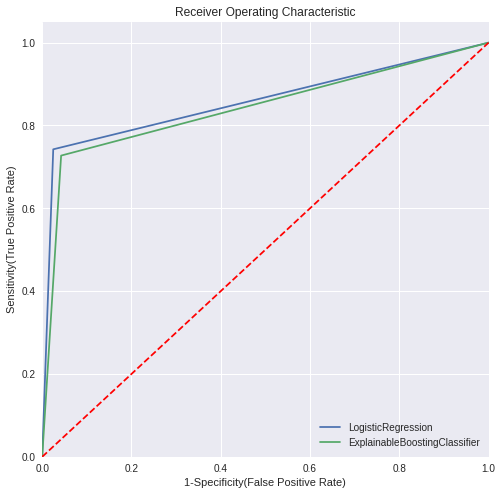

,SensLevel0,SensLevel1,AUC,AucCI_lo,AucCI_hi,SE,OpSen,SenCI_lo,SenCI_hi,OpSpe,SpeCI_lo,SpeCI_hi
"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=500,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n warm_start=False)",0.8019186429512516,0.7623023715415019,0.858845,0.799904,0.917785,0.0300724,0.742424,0.636922,0.847927,0.975265,0.957169,0.993361
"ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,\n early_stopping_tolerance=0.0001,\n feature_names=['CNN_SCORE_AXIAL23',\n 'CNN_SCORE_CORONAL43',\n 'CNN_SCORE_SAGITTAL26', 'AGE',\n 'MALE', 'YEARS_EDUCATION',\n 'HISPANIC', 'RACE_WHITE',\n 'RACE_BLACK', 'RACE_ASIAN',\n 'MARRIED',\n 'CNN_SCORE_AXIAL23 x '\n 'CNN_SCORE_CORONAL43',\n 'YEARS_EDUCATION x HISPANIC',\n 'CNN...\n 'categorical', 'interaction',\n 'interaction', 'interaction',\n 'interaction', 'interaction',\n 'interaction', 'interaction',\n 'interaction', 'interaction',\n 'interaction'],\n inner_bags=0, interactions=10, learning_rate=0.01,\n mains='all', max_bins=256,\n max_interaction_bins=32, max_leaves=3,\n max_rounds=5000, min_samples_leaf=2, n_jobs=-2,\n outer_bags=8, random_state=42,\n validation_size=0.15)",0.7863971821536397,0.7436766185843676,0.842435,0.780881,0.903989,0.0314059,0.727273,0.619825,0.83472,0.957597,0.93412,0.981075


In [25]:
df_roc,_ = plotroc(df, models=[lr,ebm])
df_roc

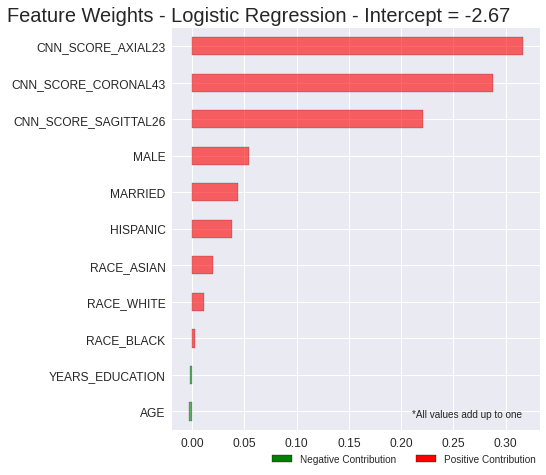

In [26]:
features = df_test.columns[:-1]
show_feature_weights(features,lr.coef_.ravel(),'Logistic Regression - Intercept = %3.2f' % lr.intercept_[0], color = ('r','g'),figsize=(6,6), absolute_values = False,normalized=True)

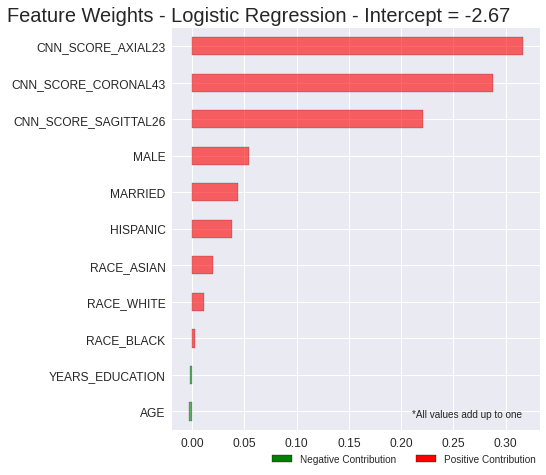

In [27]:
features = df_test.columns[:-1]
show_feature_weights(features,lr.coef_.ravel(),'Logistic Regression - Intercept = %3.2f' % lr.intercept_[0], color = ('r','g'),figsize=(6,6), absolute_values = False,normalized=True)

In [28]:
show(ebm.explain_global())

In [29]:
ebm_local = ebm.explain_local(df_test.drop('DIAGNOSIS',axis=1),df_test['DIAGNOSIS'])
show(ebm_local)

Output hidden; open in https://colab.research.google.com to view.

# Highlights of AD vs CN:

1. Demographics+CogTest Scores are too precise. AUC = 1.0
2. MRI Scores give excellent results. AUC > 0.9
3. Combining MRI Scores with demographics can lead to even better results. AUC > 0.97. 

  3.1 This is interesting because it is possible to obtain optimal results without the need of a clinical expert to conduct cognitive tests.

4. WHEN LOOKING AT THE LINEAR MODEL EXPLANATIONS: Some demographics features might be misleading. Such as the explanations for encoding of marital status (married, widow,never married) and race (hispanic,black,white,asian). Look at the Logistic Regression Graphs in Experiment3. Concerning the race, it seems like hispanics MIGHT have a higher incidence of AD, whereas any non-hispanic is less likely. This should be further investigated.
  
  4.1 That might suggest that EBM besides providing better results, also provides better explanations 

Compare Results:
  1. CNN Coronal
  2. CNN Axial
  3. CNN Sagittal
  4. Ensemble CNNs
  5. Ensemble CNNs + Demographics
  6. Ensemble CNNs + CogTest Score

Future Experiments:
- CN vs MCI